In [62]:
"""
 * @ Author: Lucas Glasner (lgvivanco96@gmail.com)
 * @ Create Time: 1969-12-31 21:00:00
 * @ Modified by: Lucas Glasner, 
 * @ Modified time: 2024-05-09 16:15:52
 * @ Description:
 * @ Dependencies:
 */
"""
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from utils import to_numeric

import glob
import os

In [63]:
params  = pd.read_csv('data/parameters.csv', index_col=0)
params  = params.map(lambda x: to_numeric(x))

basin_paths   = glob.glob('data/Basins/*')
basin_names   = [p.split('/')[-1] for p in basin_paths]
sdh_UHmodels  = {fid:xr.open_dataset(f'{p}/tmp/SDH-Run_{n}.nc',
                                     decode_timedelta=False).load()
                 for p,n,fid in zip(basin_paths, basin_names, params.columns)}
sdh_QRational = {fid:pd.read_excel(f'{p}/QRational_{n}.xlsx', index_col=0,
                                 sheet_name='peakrunoff_m3s')
                 for p,n,fid in zip(basin_paths, basin_names, params.columns)}


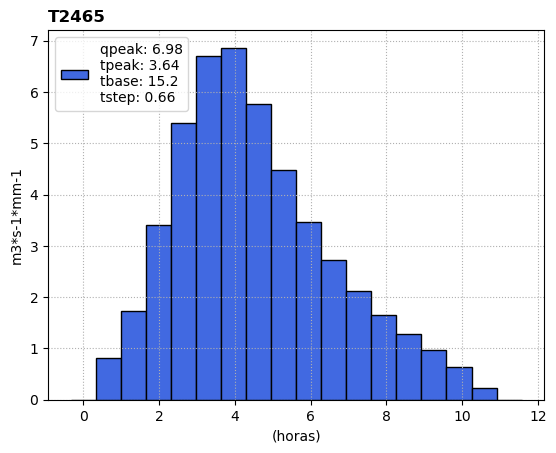

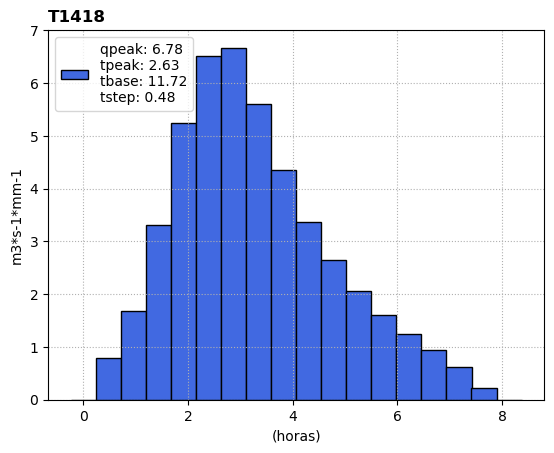

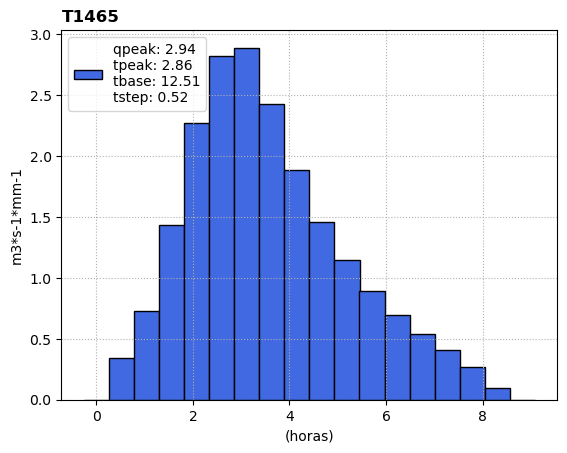

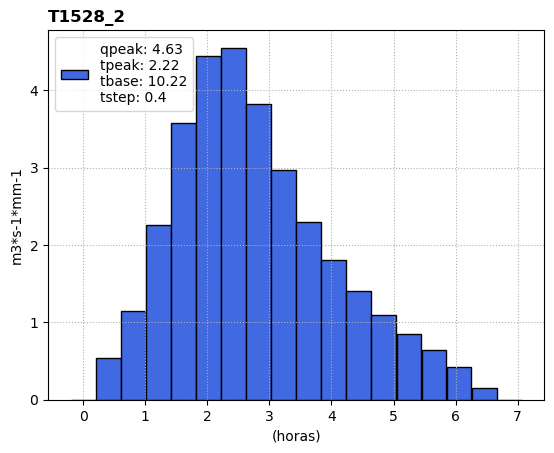

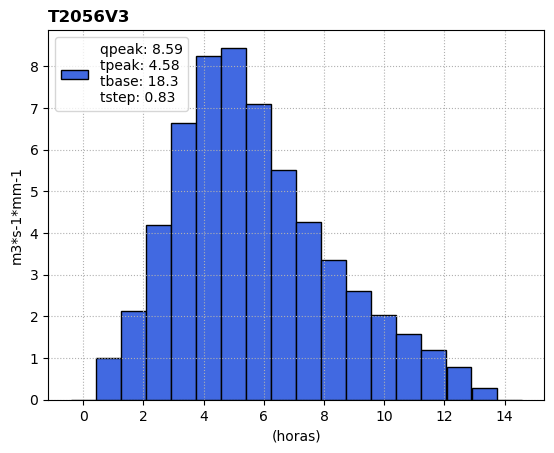

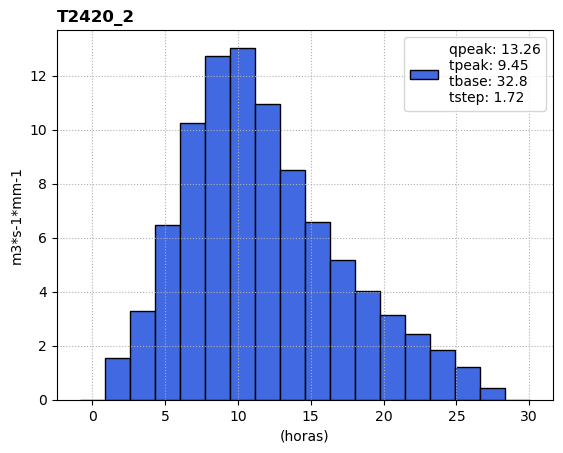

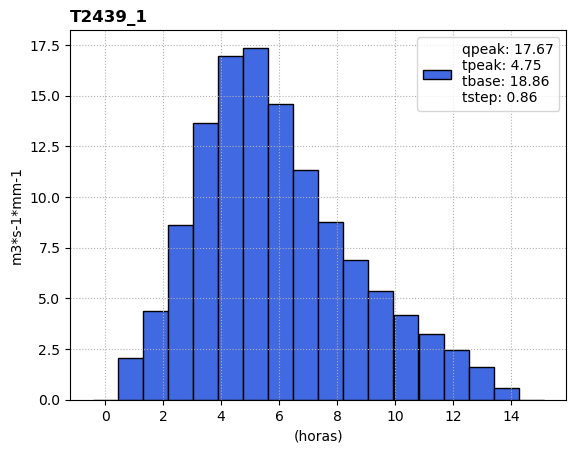

In [53]:
# ------------------------- plot and save hydrograph ------------------------- #
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid]
    basin_name = params[fid].loc['name'].replace(' ','')
    plt.figure(num=i)
    label = '\n'.join([f'{key}: {val}'
                    for key, val in sim.UnitHydro.attrs.items()][-4:])
    plt.xlabel('(horas)')
    plt.ylabel(f'{sim.UnitHydro.units}')
    plt.grid(True, ls=":")
    plt.bar(sim.UnitHydro.time, sim.UnitHydro.values,
            width=sim.UnitHydro.attrs['tstep'],
            color='royalblue',
            ec='k',
            label=label)
    plt.legend()
    plt.title(basin_name, loc='left', weight='bold')
    plt.savefig(f'data/Basins/{basin_name}/{basin_name}_UnitHydrograph.png',
                dpi=125, bbox_inches='tight')
    
    uh = sim.UnitHydro.to_series().dropna()
    uh.name = sim.UnitHydro.standard_name+'  '+sim.UnitHydro.units
    uh.to_excel(f'data/Basins/{basin_name}/{basin_name}_Results.xlsx',
                sheet_name='UnitHydrograph')

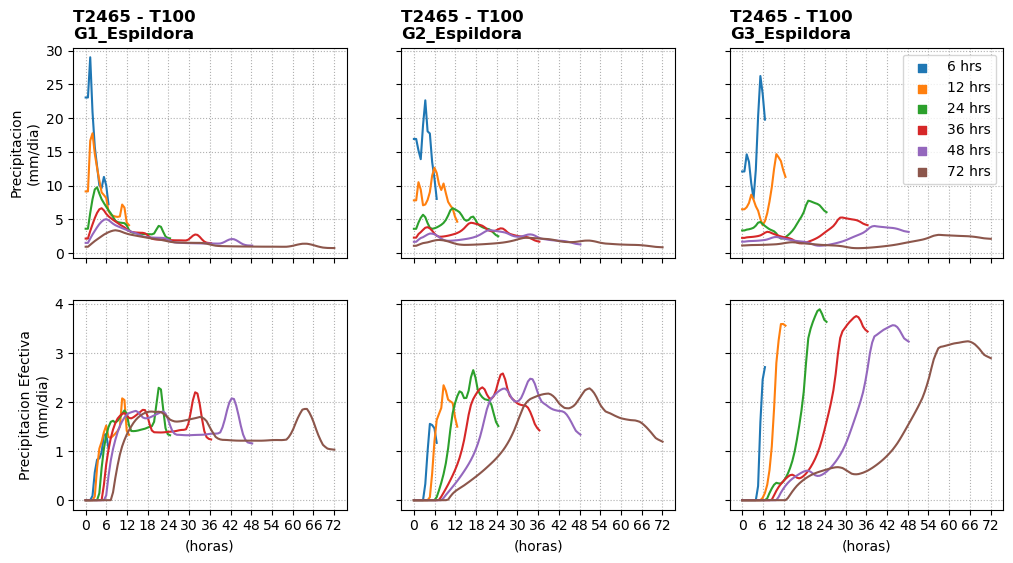

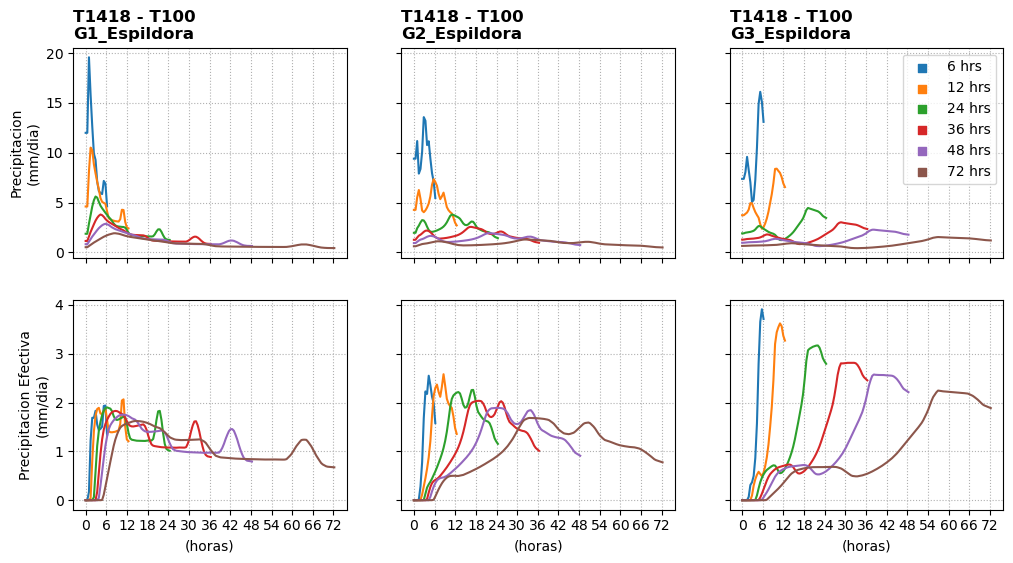

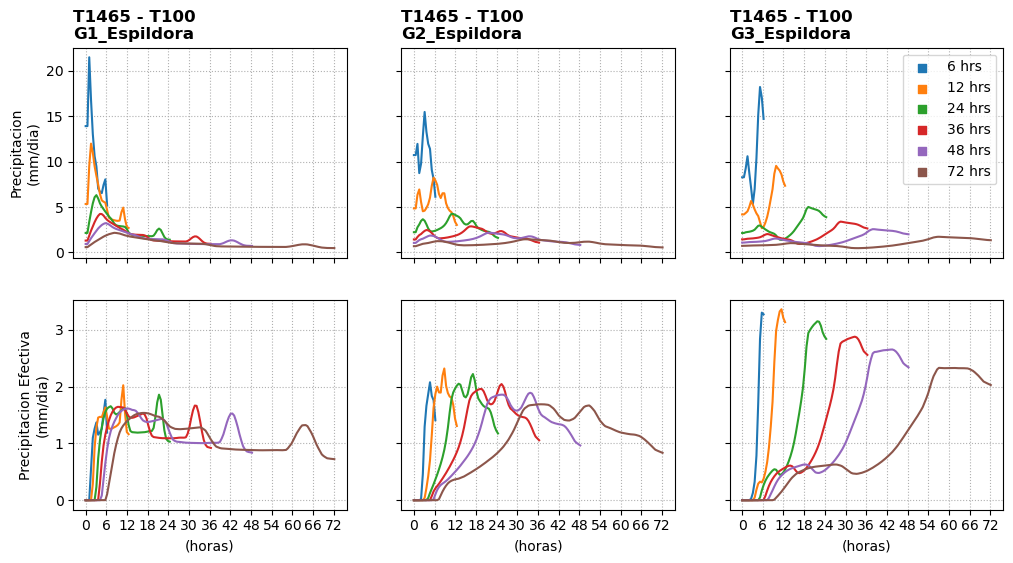

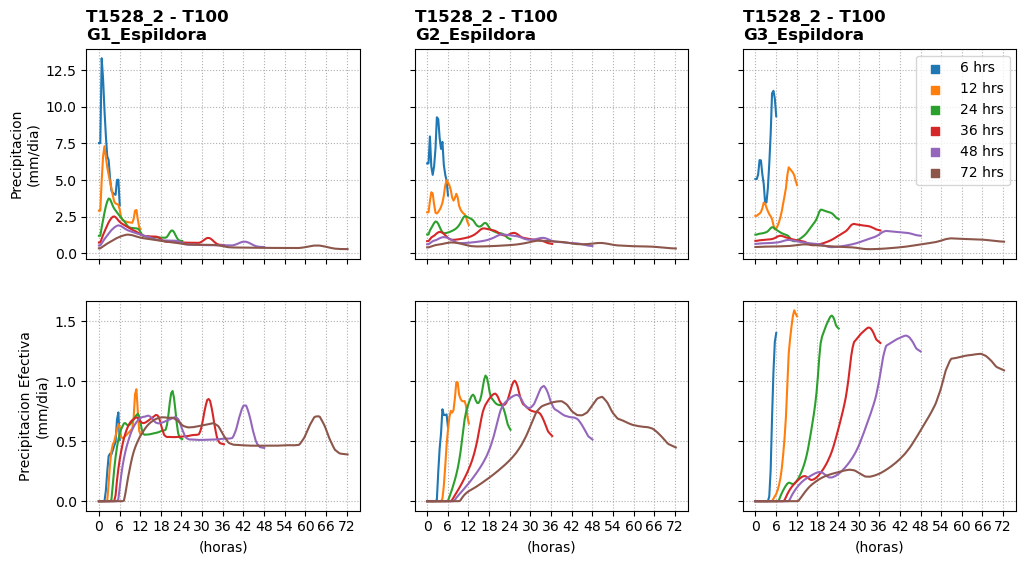

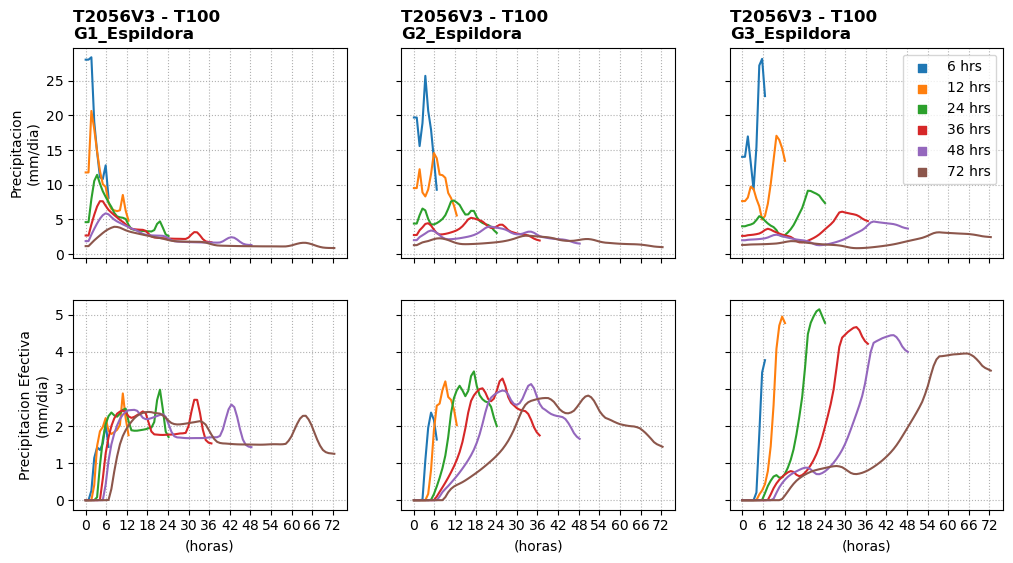

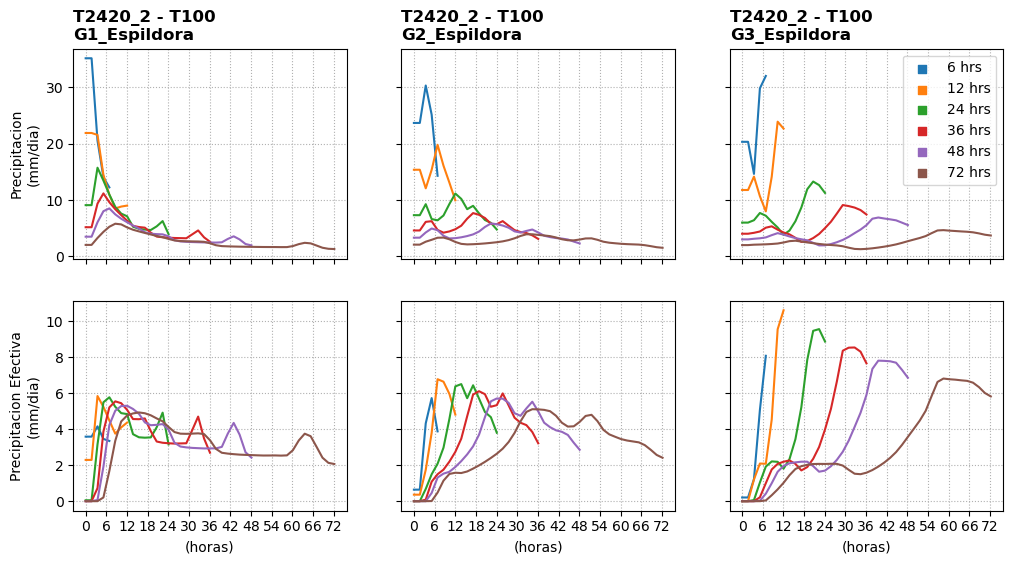

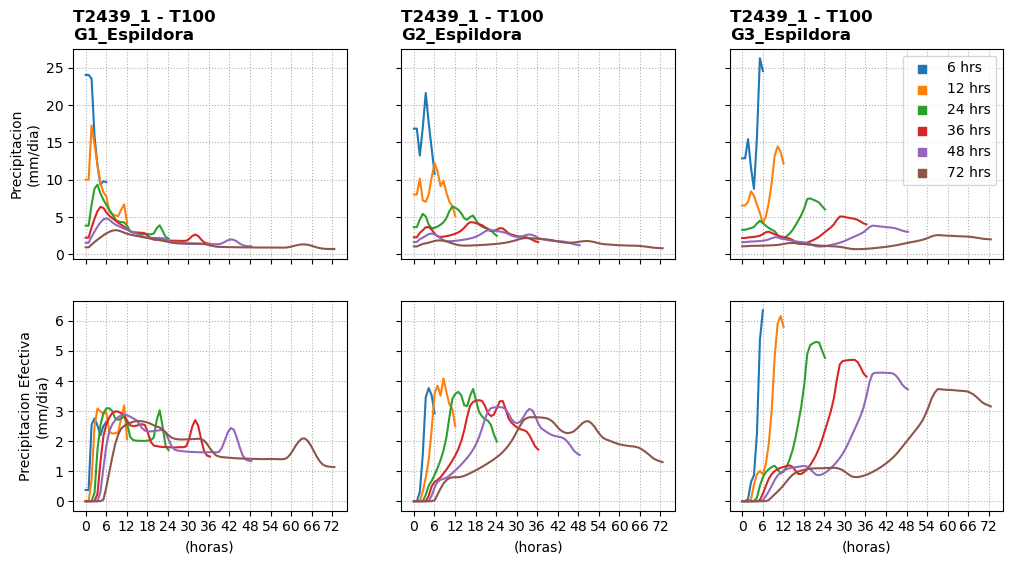

In [54]:
# --------------------------- plot design storms - --------------------------- #
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid].sel(return_period=100,
                              storm_duration=[6,12,24,36,48,72])
    basin_name = params[fid].loc['name'].replace(' ','')
    n_dstorms = sim.shyeto.shape[0]
    fig, ax = plt.subplots(2, n_dstorms, figsize=(n_dstorms*4, 6),
                           sharex=True, sharey='row')
    for j, shyeto in enumerate(sim.shyeto):
        ax[0,j].set_title(f'{basin_name} - T100\n{shyeto.item()}', loc='left',
                          weight='bold')
        pr = sim.pr.sel(shyeto=shyeto).to_dataframe()['pr'].unstack().T
        ax[0,j].plot(pr.index,pr)
        
        pr = sim.pr_eff.sel(shyeto=shyeto).to_dataframe()['pr_eff'].unstack().T
        ax[1,j].plot(pr.index,pr)
        ax[1,j].set_xlabel('(horas)')
    
    for axis in ax.ravel():
        axis.set_xticks(np.arange(0,72+6,6))
        axis.grid(True, ls=":")
    ax[0,0].set_ylabel('Precipitacion\n(mm/dia)')
    ax[1,0].set_ylabel('Precipitacion Efectiva\n(mm/dia)')
    for k,dt in enumerate(sim.storm_duration):
        ax[0,-1].scatter([], [], label=f'{dt.item()} hrs', marker='s')
    ax[0,-1].legend()
    plt.savefig(f'data/Basins/{basin_name}/tmp/{basin_name}_DesignStorms.png',
                dpi=125, bbox_inches='tight')

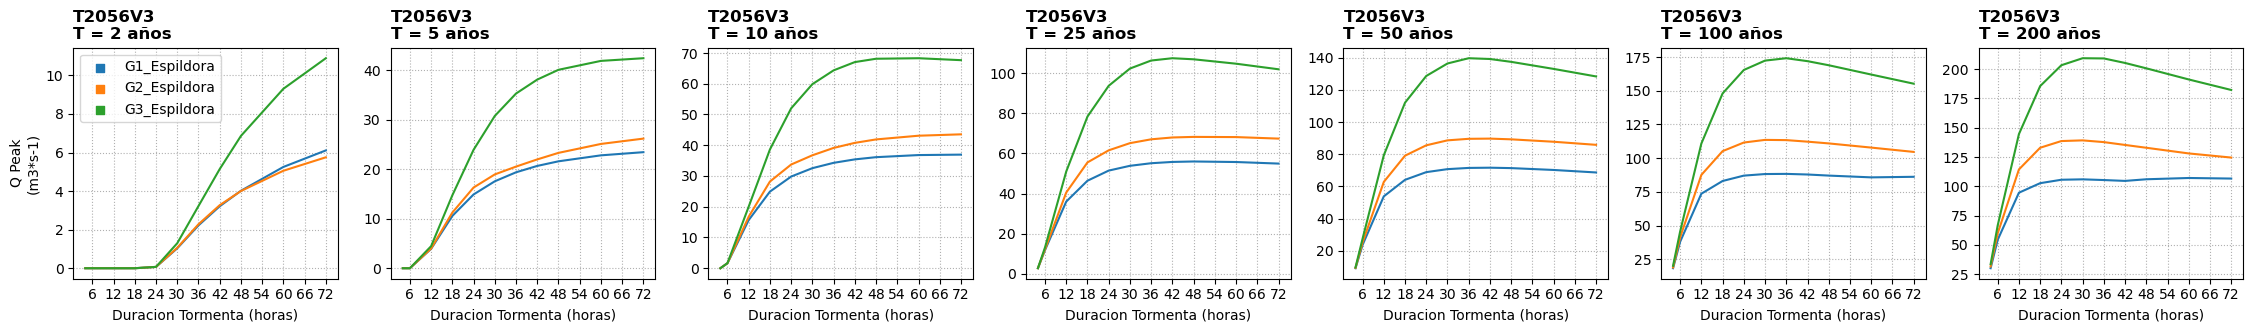

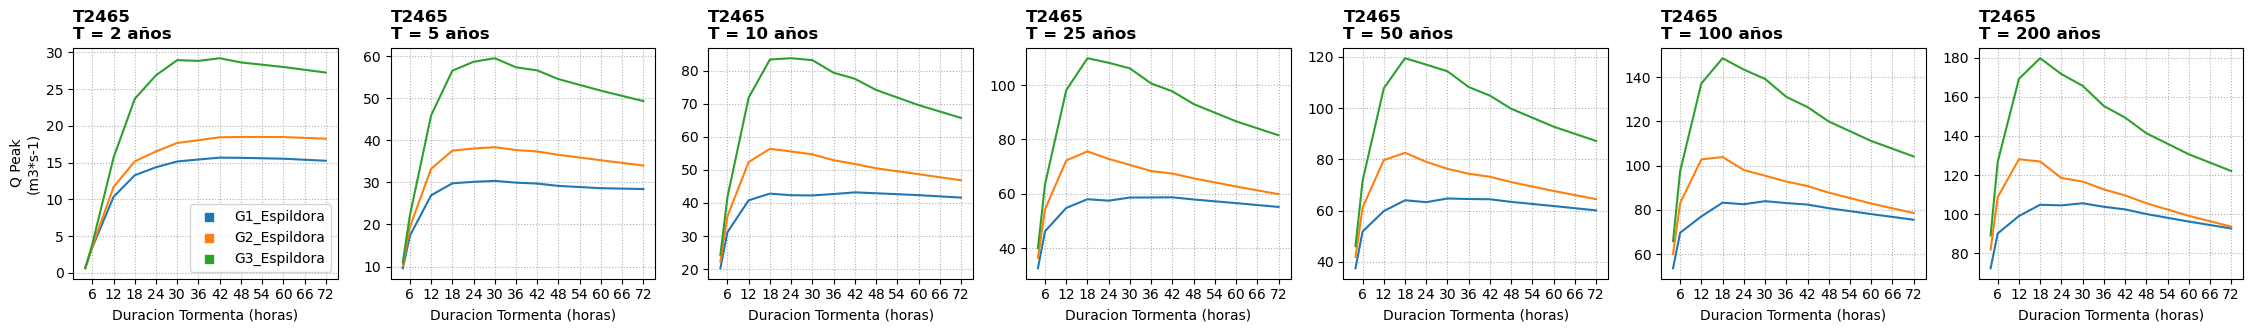

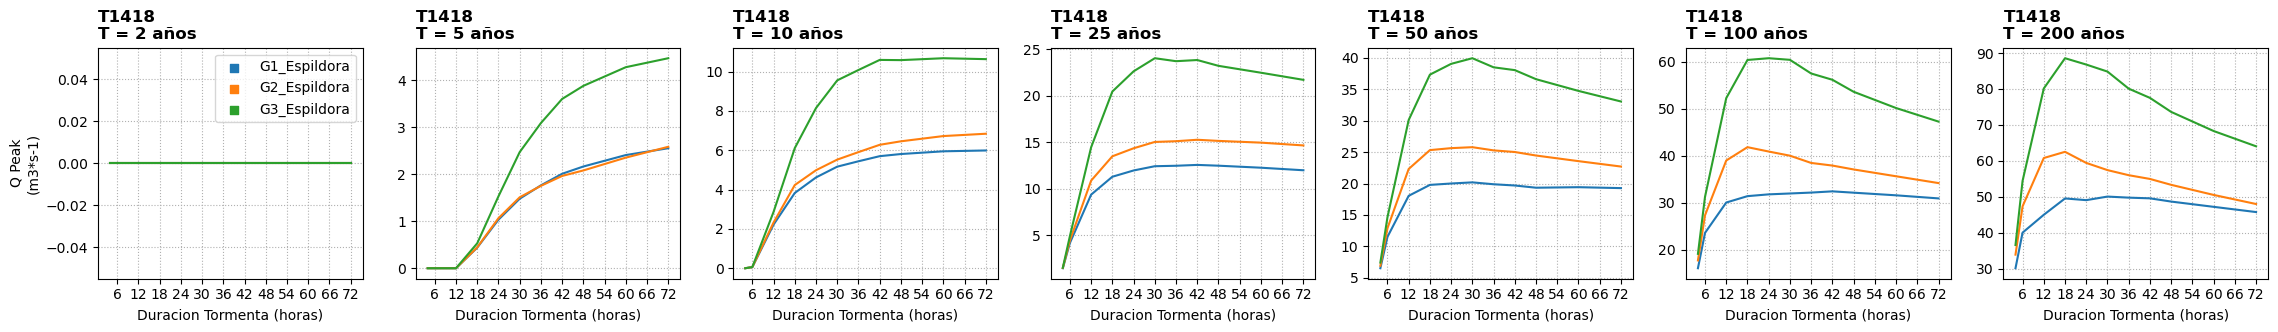

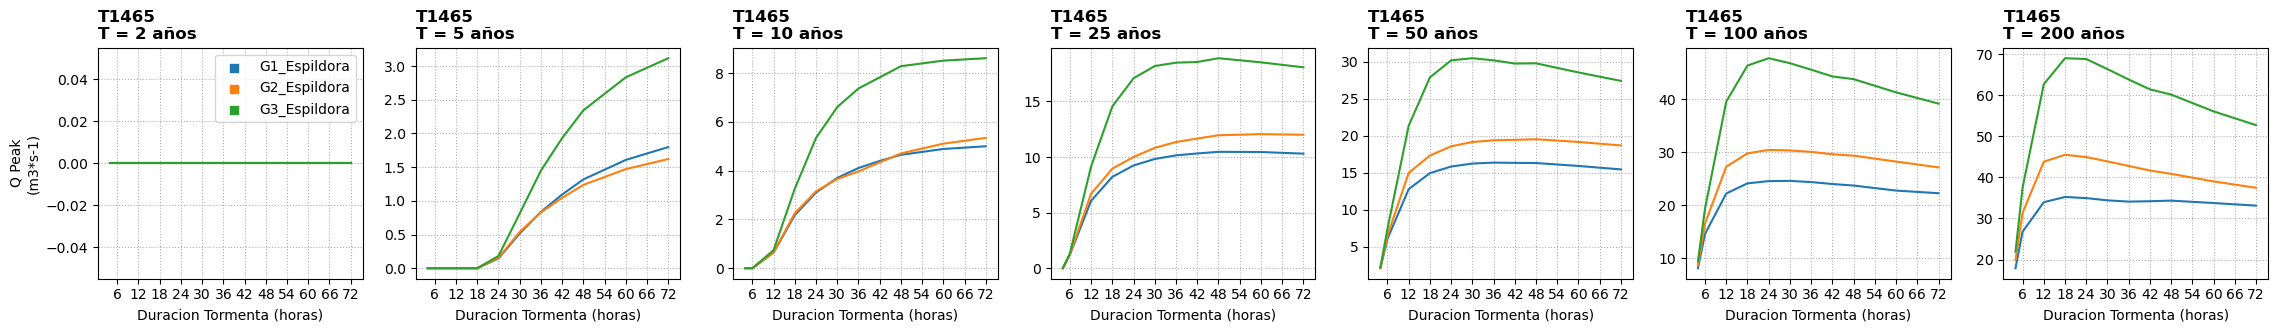

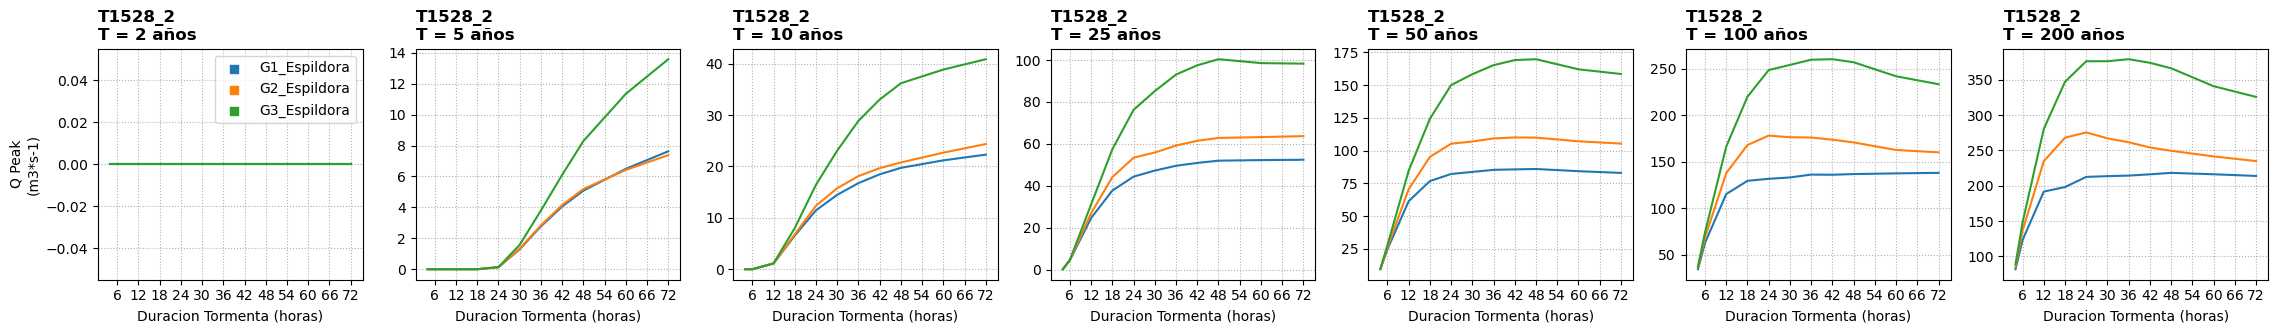

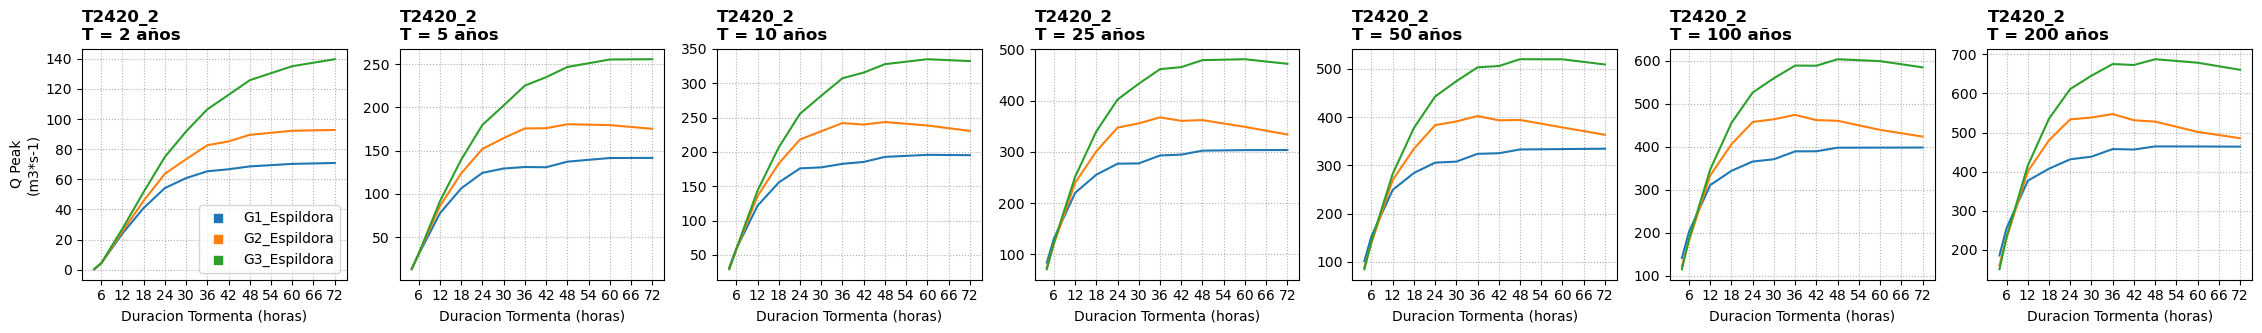

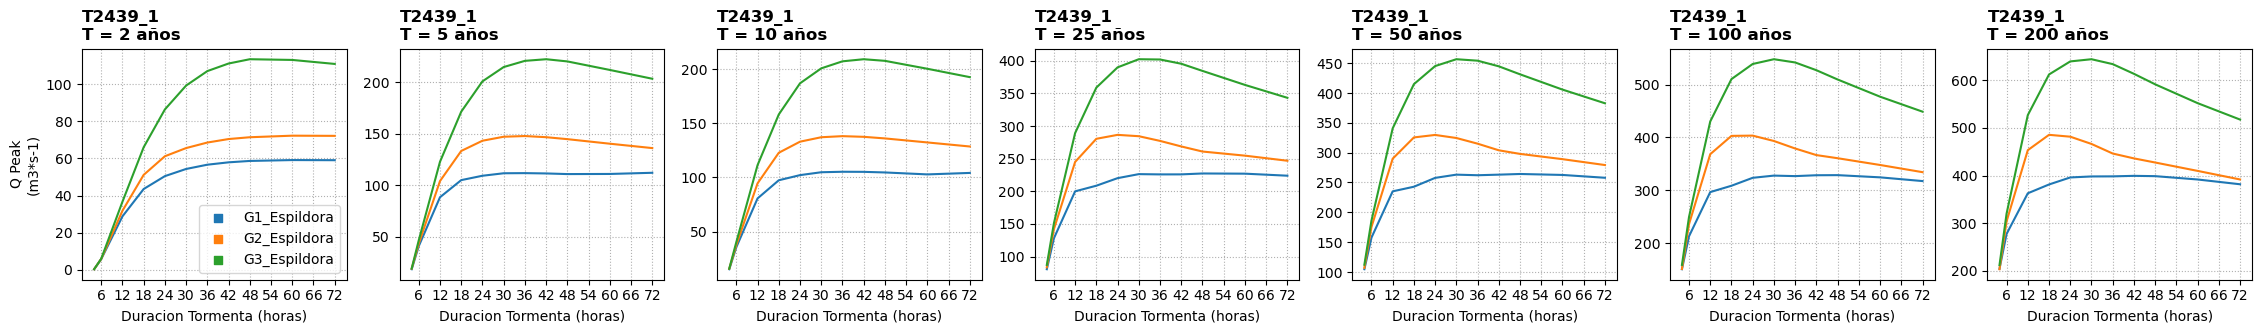

In [55]:
# ----------------------- plot peak hydrograph runoffs ----------------------- #
for i,fid in enumerate(params.columns):
    sim = sdh_UHmodels[fid]
    basin_name = params[fid].loc['name'].replace(' ','')
    qpeak = sim.runoff.max('time')
    basin_name = sim.attrs['name'].replace(' ','')
    n_returnp = sim.return_period.shape[0]
    fig, ax = plt.subplots(1, n_returnp, figsize=(n_returnp*4, 3),
                           sharex=True, sharey=False)
    for j, T in enumerate(sim.return_period):
        q = qpeak.sel(return_period=T)
        q = q.to_dataframe()['runoff'].unstack()
        ax[j].plot(q.index, q)
        ax[j].set_xticks(np.arange(0,72+6,6))
        ax[j].grid(True, ls=":")
        ax[j].set_xlabel('Duracion Tormenta (horas)')
        ax[j].set_title(f'{basin_name}\nT = {T.item()} años',
                        loc='left', weight='bold')
    for k,shyeto in enumerate(sim.shyeto):
        ax[0].scatter([], [], label=shyeto.item(), marker='s')
    ax[0].legend()
    ax[0].set_ylabel('Q Peak\n(m3*s-1)')
    plt.savefig(f'data/Basins/{basin_name}/tmp/{basin_name}_PeakRunoffs.png',
                dpi=125, bbox_inches='tight')


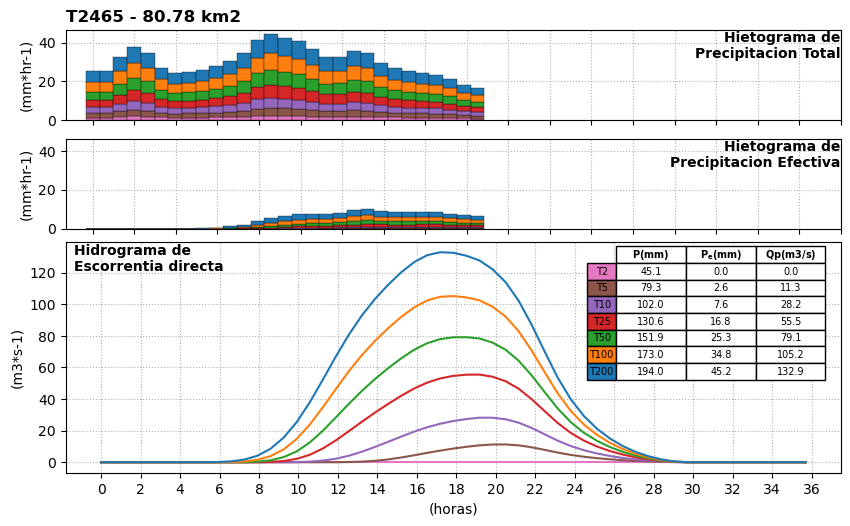

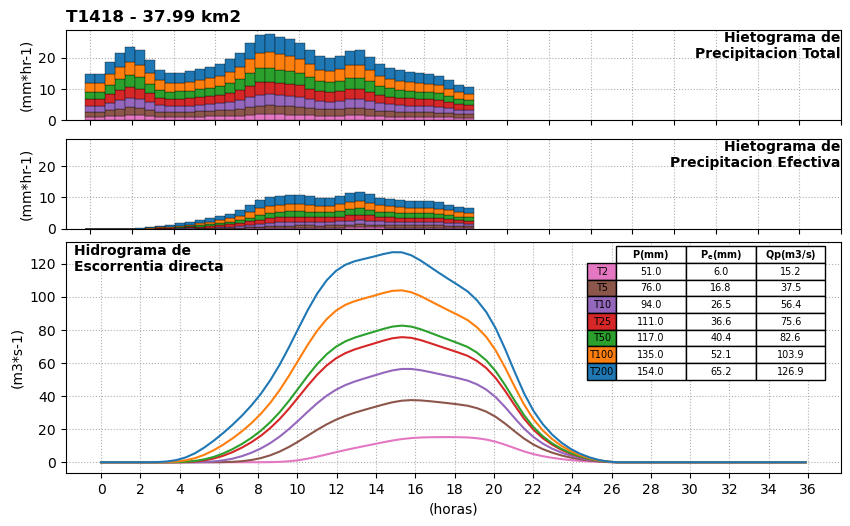

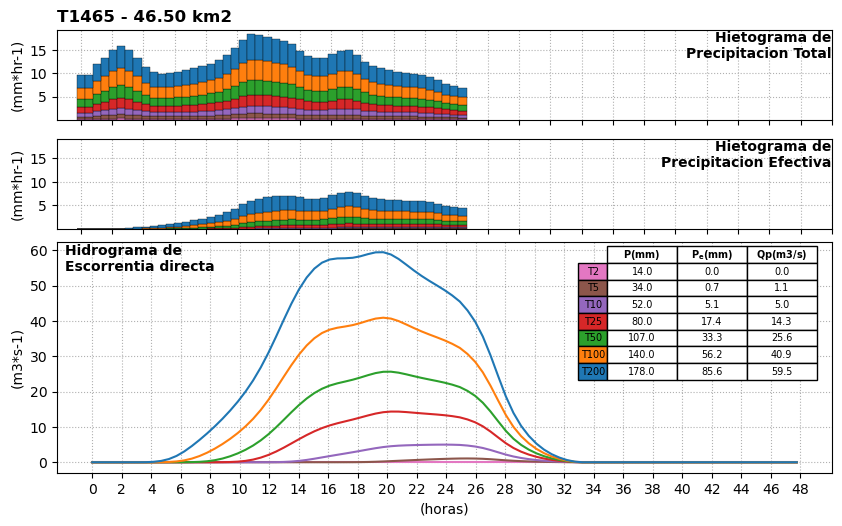

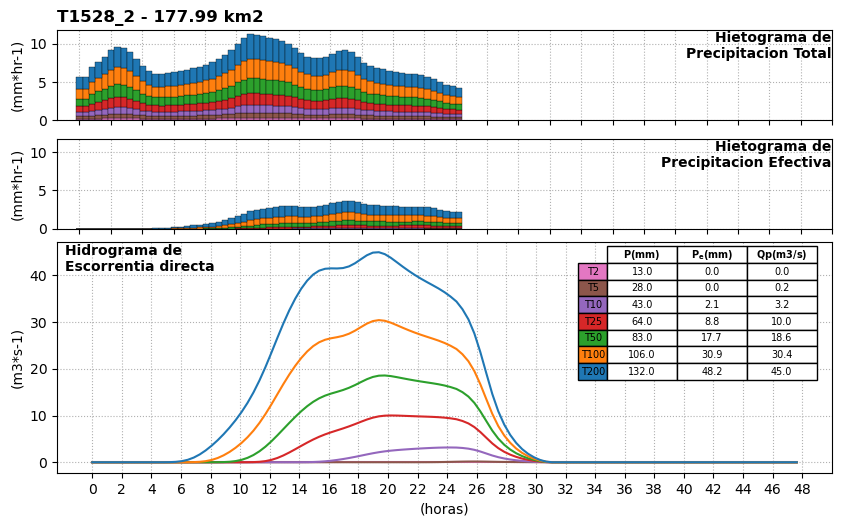

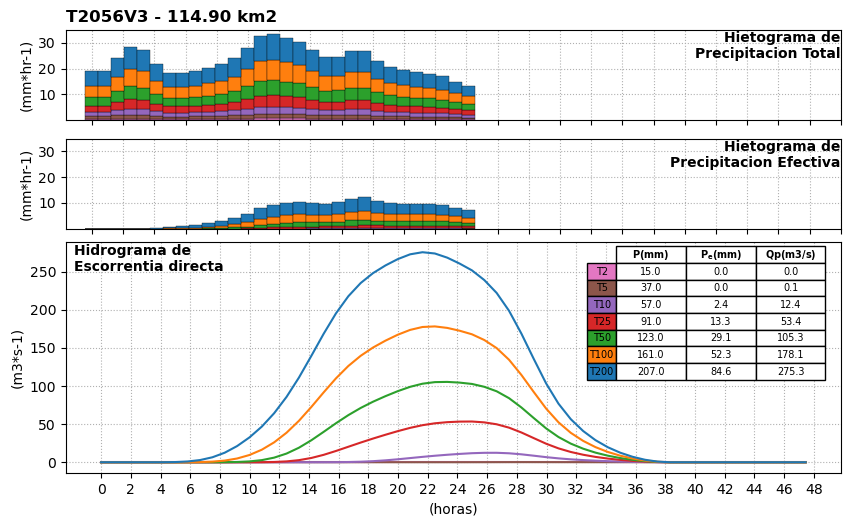

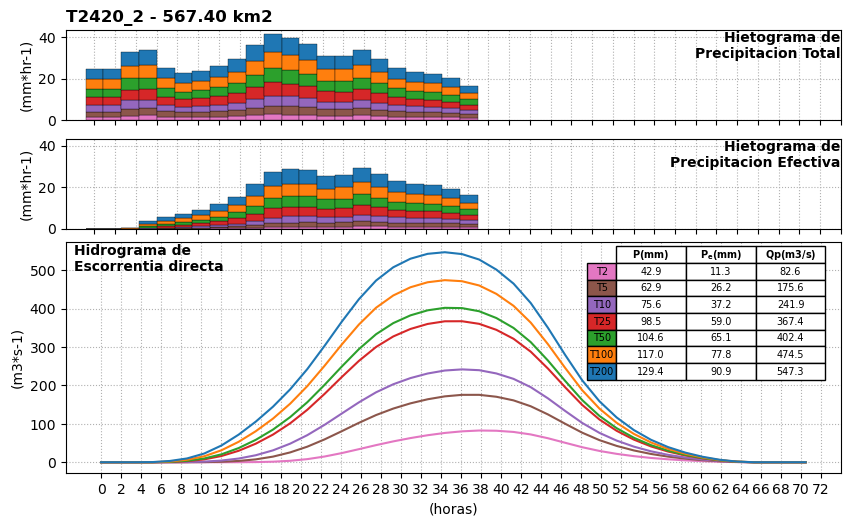

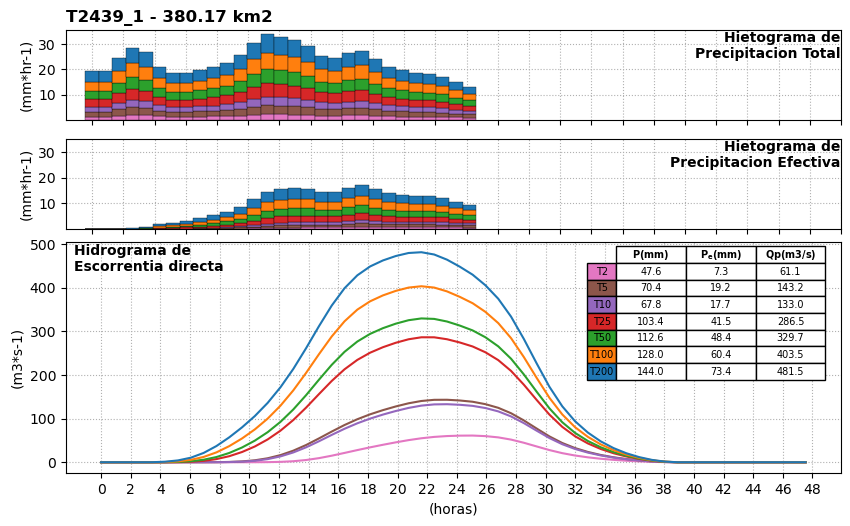

In [168]:
design_durations = pd.Series([18,18,24,24,24,36,24], index=params.columns)
hyetographs      = pd.Series(['G2_Espildora']*len(params.columns),
                             index=params.columns)
for i,fid in enumerate(params.columns):
    name = params[fid].loc['name'].replace(' ','')
    sim = sdh_UHmodels[fid]
    sim = sim.sel(shyeto=hyetographs[fid])
    sim = sim.sel(storm_duration=design_durations.loc[fid])
    sim = sim.sel(time=slice(0, design_durations.loc[fid]*2))
    sim = sim.to_dataframe()[['pr','pr_eff','runoff']].unstack(0)
    colors = plt.cm.tab10(np.linspace(0,1,10))[:sim.pr.columns.shape[0]][::-1]
    
    fig = plt.figure(figsize=(10,3))
    ax  = fig.add_subplot(111)
    ax.set_xticks(np.arange(0,np.ceil(sim.index.max())+2,2))
    ax.grid(True, ls=":")

    box = ax.get_position()
    ax2 = fig.add_axes([box.xmin, box.ymax*1.05, box.xmax-box.xmin, 0.3])
    ax3 = fig.add_axes([box.xmin, ax2.get_position().ymax*1.05,
                        box.xmax-box.xmin, 0.3])

    for i in range(len(sim.pr_eff.columns)):
        qpeak = sim.runoff.iloc[:,i].max()
        width = sim.index[1]-sim.index[0]
        ax.plot(sim.index,sim.runoff.iloc[:,i], color=colors[i])
        ax2.bar(sim.index,sim.pr_eff.iloc[:,i],
                bottom=sim.pr_eff.iloc[:,:i].sum(axis=1),
                width=width, ec='k', zorder=10, color=colors[i], lw=0.25)
        ax3.bar(sim.index,sim.pr.iloc[:,i],
                bottom=sim.pr.iloc[:,:i].sum(axis=1),
                width=width, ec='k', zorder=10, color=colors[i], lw=0.25)
    ax.set_xlabel('(horas)')
    ax.set_ylabel('(m3*s-1)')
    
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels([]);
    ax2.grid(True, ls=":", zorder=0)
    ax2.set_ylabel('(mm*hr-1)')
    ax2.sharey(ax3)
    
    ax3.set_xticks(ax.get_xticks())
    ax3.set_xticklabels([]);
    ax3.grid(True, ls=":", zorder=0)
    
    ax3.set_ylabel('(mm*hr-1)')
    ax3.set_title(f'{name} - {params[fid].area_km2:.2f} km2',
                  loc='left', weight='bold')
    ax3.text(0.999,0.99,'Hietograma de\nPrecipitacion Total', weight='bold',
            ha='right', va='top', transform=ax3.transAxes)
    ax2.text(0.999,0.99,'Hietograma de\nPrecipitacion Efectiva', weight='bold',
            ha='right', va='top', transform=ax2.transAxes)
    ax.text(0.01,0.99, 'Hidrograma de\nEscorrentia directa\n',
            ha='left', va='top', transform=ax.transAxes,
            weight='bold')
    
    table = pd.concat([sim.pr.sum(), sim.pr_eff.sum(), sim.runoff.max()],
                      axis=1).round(1)
    table.index = [f'T{x}' for x in table.index]
    table.index.name = ''
    table.columns = ['$\\bf{P (mm)}$', '$\\bf{P_e (mm)}$', '$\\bf{Qp (m3/s)}$']
    
    ax.table(cellText=table.values, 
            rowLabels=table.index, rowColours=colors,
            colLabels=table.columns, colWidths = [0.09]*len(table.columns),
            cellLoc = 'center', rowLoc = 'center',
            loc='best', zorder=20, edges='closed')
    
    plt.savefig(f'data/Basins/{name}/{name}_FloodHydrograph.png',
                dpi=125, bbox_inches='tight')
    
    
    out = f'data/Basins/{name}/{name}_Results.xlsx'
    with pd.ExcelWriter(out, mode='w', engine='openpyxl') as writer:
        # Store design storm
        sim['pr'].to_excel(writer, sheet_name='rainfall_mmhr-1')
        
    with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
        # Store design storm
        sim['pr_eff'].to_excel(writer, sheet_name='effective_rainfall_mmhr-1')
        
    with pd.ExcelWriter(out, mode='a', engine='openpyxl') as writer:
        # Store design storm
        sim['runoff'].to_excel(writer, sheet_name='runoff_m3s-1')